In [1]:
import os
import scanpy
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import re
import sklearn
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from collections import Counter
import random
import seaborn
import sys
import shutil
import scvelo as scv
import bbknn
import tqdm
#Load my pipeline functions
import importlib
import importlib.util
spec = importlib.util.spec_from_file_location("ScanpyUtilsMT", os.path.expanduser("../../utils/ScanpyUtilsMT.py"))
sc_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sc_utils)
sc.settings.figdir='/wynton/group/ye/mtschmitz/figures/macWbSupervise/'
scv.settings.figdir='/wynton/group/ye/mtschmitz/figures/macWbSupervise/'
sc.settings.file_format_figs='pdf'
sc.settings.autosave=False
sc.settings.autoshow=True
import cellrank as cr

In [2]:
newfile='/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityDYNAMICALMouseWbGe.h5ad'
adata=sc.read(newfile)


In [3]:
from random import random
adata=adata[np.random.choice(adata.obs.index,15000,replace=False),:]

Trying to set attribute `.uns` of view, copying.


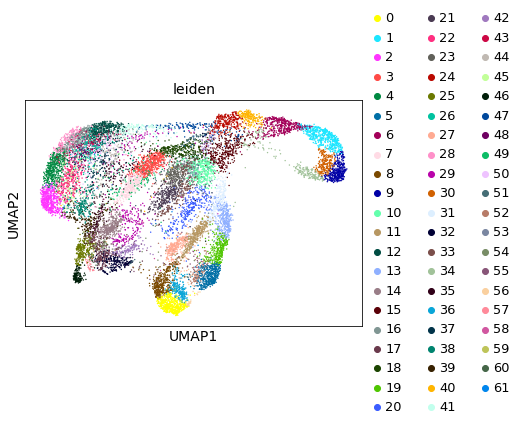

In [4]:
%matplotlib inline
sc.pl.umap(adata,color='leiden')

In [5]:
transition_matrix=scv.utils.get_transition_matrix(adata,vkey='linear_velocity',self_transitions=True)
transition_matrix=transition_matrix.astype(np.float64)
#transition_matrix=(transition_matrix.T/transition_matrix.sum(1)).T

transition_matrix[np.arange(0,transition_matrix.shape[0]),transition_matrix.argmax(1).A1]+=(1.0-transition_matrix.sum(1).A1)


vk = cr.tl.kernels.PrecomputedKernel(transition_matrix,adata=adata)
#vk = cr.tl.kernels.VelocityKernel(adata,vkey='linear_velocity')
ck = cr.tl.kernels.ConnectivityKernel(adata)
ck.compute_transition_matrix()
vk.compute_transition_matrix()

ckvk=vk+ck
ckvk.compute_transition_matrix()


((0.5 * <PrecomputedKernel[origin='array']>) + (0.5 * <ConnectivityKernel>))

Schur complete


ValueError: Discretizing leads to a cluster with `8` samples, less than the threshold which is `10` samples. Consider recomputing the fuzzy clustering.

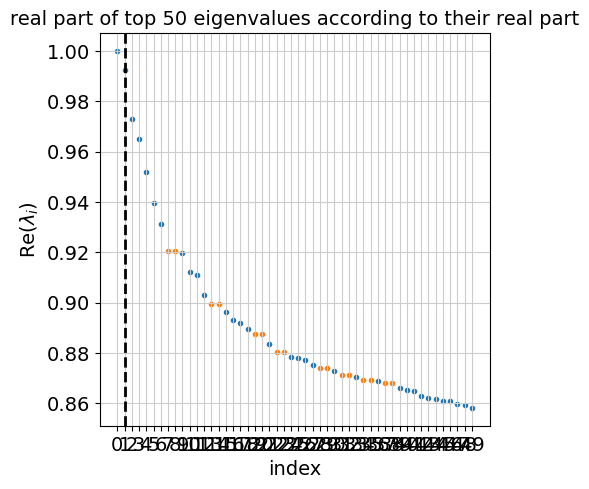

In [6]:
g = cr.tl.estimators.GPCCA(ckvk)
#g.compute_eigendecomposition()
g.compute_schur(n_components=50,method='krylov')
print('Schur complete',flush=True)
g.plot_spectrum(real_only=True,save='spectrum')


In [7]:
g.compute_macrostates(n_states=50, n_cells=25,cluster_key="supervised_name")
print('Macrostates computed', flush=True)
#adata.write('/wynton/home/ye/mschmitz1/GPCCAmacrostatesmouseAdult2.h5ad')
adata.uns['macrostates']=list(g.macrostates.cat.categories)
g.compute_terminal_states()
cr.tl.initial_states(adata, cluster_key='supervised_name')

Macrostates computed


ValueError: No macrostates have been selected.

In [11]:
g.macrostates.value_counts()

LGE_FOXP1/ISL1_1        25
LGE_FOXP1/ISL1/NPY1R    25
Transition_5            25
S-phase_MCM4/H43C_7     25
Transition_6            25
G2-M_UBE2C/ASPM_2       25
LGE_FOXP1/PENK_5        25
S-phase_MCM4/H43C_8     25
G2-M_UBE2C/ASPM_3       25
G2-M_UBE2C/ASPM_4       25
S-phase_MCM4/H43C_9     25
LGE_FOXP1/PENK_6        25
RMTW_ZIC1/RELN_2        25
G2-M_UBE2C/ASPM_5       25
S-phase_MCM4/H43C_10    25
LGE_FOXP1/ISL1_5        25
S-phase_MCM4/H43C_11    25
MGE_LHX6/MAF_3          25
LGE_MEIS2/PAX6_2        25
LGE_FOXP1/ISL1_6        25
CGE_NR2F2/PROX1_4       25
LGE_FOXP1/ISL1_7        25
G2-M_UBE2C/ASPM_1       25
MGE_LHX6/MAF_4          25
CGE_NR2F2/PROX1_3       25
S-phase_MCM4/H43C_1     25
VMF_TMEM163/OTP         25
LGE_FOXP2/TSHZ1         25
Transition_2            25
S-phase_MCM4/H43C_4     24
MGE_LHX6/MAF_1          24
LGE_FOXP1/PENK_4        23
LGE_FOXP1/ISL1_4        23
S-phase_MCM4/H43C_5     23
S-phase_MCM4/H43C_6     23
LGE_FOXP1/PENK_2        22
Transition_1            21
S

In [31]:
df=pd.DataFrame(adata[:,adata.var['highly_variable']].X)
df['leiden']=list(adata.obs.leiden)
df1=df.groupby(['leiden']).mean()
corr =df1.T.corr() 


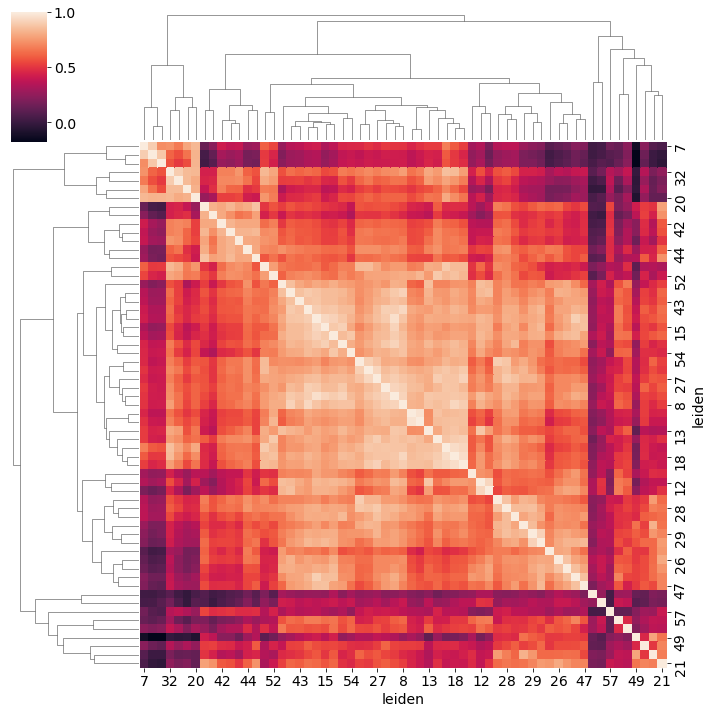

In [30]:
seaborn.clustermap(df1.T.corr())

In [63]:
adata=adata[:,adata.var.highly_variable]

In [79]:
import statsmodels
import statsmodels.formula.api as smf

for c in corr.columns:
    for p in corr[c].sort_values(ascending=False).index[1:4]:
        print(c,p)
        thisadata=adata[adata.obs.leiden.isin([c,p]),:].copy()
        parameters=[]
        for i in tqdm.tqdm(range(thisadata.shape[1])):
            df=pd.DataFrame({'y':thisadata.X[:,i],'latent_time':thisadata.obs['latent_time'],'leiden':thisadata.obs['leiden']})
            model = smf.ols('y ~ latent_time + leiden', data=df)
            model = model.fit()
            parameters.append(model.params)
        paramdf=pd.DataFrame(parameters)
        print(np.mean(np.abs(paramdf.iloc[:,0])))
        print(np.mean(np.abs(paramdf.iloc[:,1])))
        print(np.mean(np.abs(paramdf.iloc[:,2])))

0 29


100%|██████████| 15000/15000 [01:39<00:00, 150.55it/s]


0.08227080077576267
0.028177177656776558
0.11876562917390454
0 28


100%|██████████| 15000/15000 [01:38<00:00, 152.28it/s]


0.08107667678823904
0.019031167020447385
0.11735266364650529
0 9


100%|██████████| 15000/15000 [01:37<00:00, 154.36it/s]


0.08243976631607851
0.01644836458619545
0.1159556796872159
1 0


100%|██████████| 15000/15000 [01:37<00:00, 154.09it/s]


0.07880304239848408
0.020821896428082888
0.09546350851710157
1 49


100%|██████████| 15000/15000 [01:36<00:00, 156.12it/s]


0.07337865272901226
0.03217487754665943
0.11362498749129392
1 25


  2%|▏         | 240/15000 [00:01<01:35, 154.50it/s]


KeyboardInterrupt: 

In [55]:
df
# Initialise and fit linear regression model using `statsmodels`
model = smf.ols('y ~ latent_time + leiden', data=df)
model = model.fit()

In [78]:
paramdf

,Intercept,leiden[T.1],latent_time
0,-0.028578,-3.808463e-03,5.698136e-03
1,-0.005755,-3.252607e-19,-4.336809e-18
2,-0.023702,-1.517883e-18,-1.040834e-17
3,-0.009027,-3.794708e-19,-1.734723e-18
4,-0.017346,4.350658e-03,-1.479575e-02
...,...,...,...
2211,-0.093963,6.780377e-02,1.487754e-01
2212,-0.469013,1.759750e-01,1.920136e+00
2213,-0.143425,5.498367e-02,3.946068e-01
2214,-0.028990,-1.972467e-03,-2.534518e-02


<AxesSubplot:xlabel='latent_time'>

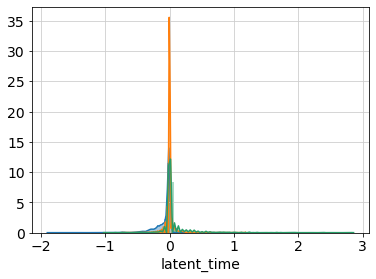

In [73]:
paramdf=pd.DataFrame(parameters)
seaborn.distplot(paramdf.iloc[:,0])
seaborn.distplot(paramdf.iloc[:,1])
seaborn.distplot(paramdf.iloc[:,2])


In [74]:
np.mean(np.abs(paramdf.iloc[:,0]))


0.08081641355724324

In [76]:
np.mean(np.abs(paramdf.iloc[:,1]))


0.020293183068854366

In [75]:
np.mean(np.abs(paramdf.iloc[:,2]))


0.0990924017019991

In [33]:
import sklearn
print(sklearn.metrics.adjusted_rand_score(adata.obs['supervised_name'], adata.obs['leiden']))

0.13956271493994532


In [81]:
sc.tl.leiden(adata,resolution=3)
print(sklearn.metrics.adjusted_rand_score(adata.obs['supervised_name'], adata.obs['leiden']))
sc.tl.leiden(adata,resolution=5)
print(sklearn.metrics.adjusted_rand_score(adata.obs['supervised_name'], adata.obs['leiden']))
sc.tl.leiden(adata,resolution=7)
print(sklearn.metrics.adjusted_rand_score(adata.obs['supervised_name'], adata.obs['leiden']))
sc.tl.leiden(adata,resolution=10)
print(sklearn.metrics.adjusted_rand_score(adata.obs['supervised_name'], adata.obs['leiden']))

0.3764935710957204
0.29140015436649225
0.2101990528091574
0.14407144545056055


In [86]:
adata.uns['linear_velocity_graph']

<15000x15000 sparse matrix of type '<class 'numpy.float32'>'
	with 422943 stored elements in Compressed Sparse Row format>

In [87]:
scv.tl.paga(
    adata,vkey='linear_velocity',
    groups="leiden",
    root_key="initial_states_probs",
    end_key="terminal_states_probs",
    use_time_prior="latent_time",
)

running PAGA using priors: ['latent_time']
    finished (0:00:10) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


the obs value 'leiden' has more than 103 categories. Uniform 'grey' color will be used for all categories.


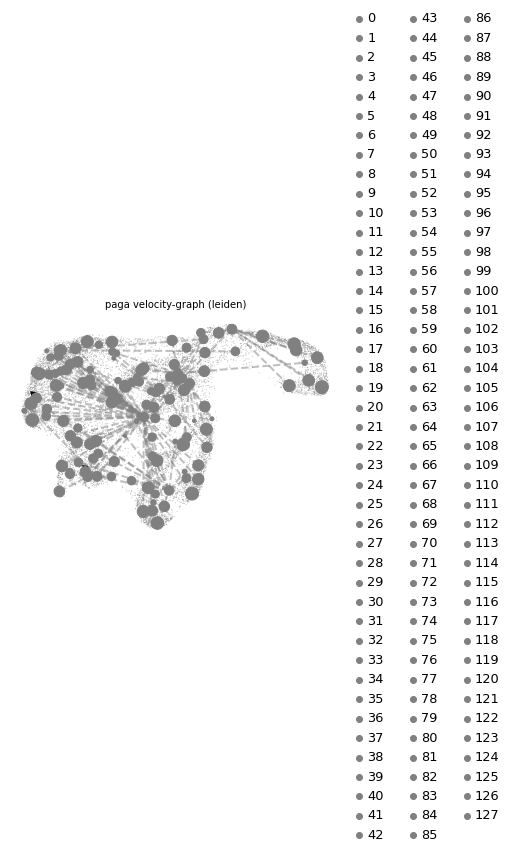

In [89]:
scv.pl.paga(adata,dashed_edges='connectivities_tree',basis='umap')

In [88]:
adata.uns['paga']['connectivities_tree']

{'connectivities': <128x128 sparse matrix of type '<class 'numpy.float64'>'
 	with 11854 stored elements in Compressed Sparse Row format>,
 'connectivities_tree': <128x128 sparse matrix of type '<class 'numpy.float64'>'
 	with 127 stored elements in Compressed Sparse Row format>,
 'transitions_confidence': <128x128 sparse matrix of type '<class 'numpy.float64'>'
 	with 4 stored elements in Compressed Sparse Column format>,
 'threshold': 0.010243325682741663,
 'groups': 'leiden'}

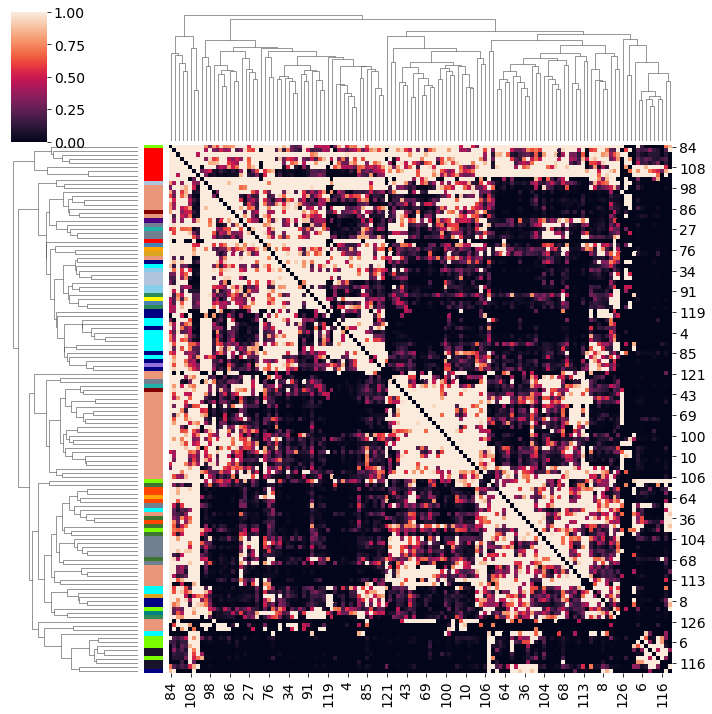

In [94]:
most_common_sn=pd.DataFrame(adata.obs.groupby('leiden')['supervised_name'].value_counts().unstack().idxmax(1))
color_dict=dict(zip(adata.obs.supervised_name.cat.categories,adata.uns['supervised_name_colors']))
row_colors = [color_dict[x] for x in most_common_sn[0]]
mat=pd.DataFrame(adata.uns['paga']['connectivities'].todense(),index=adata.obs.leiden.cat.categories)
seaborn.clustermap(mat,method='average',row_colors=row_colors)


In [ ]:
sc.tl.dendrogram(adata,groupby='leiden')
most_common_sn=pd.DataFrame(adata.obs.groupby('leiden')['agg_supervised_name'].value_counts().unstack().idxmax(1))
color_dict=dict(zip(adata.obs.agg_supervised_name.cat.categories,adata.uns['agg_supervised_name_colors']))
row_colors = [color_dict[x] for x in most_common_sn[0]]
mat=pd.DataFrame(adata.uns['dendrogram_leiden']['correlation_matrix'],index=adata.obs.leiden.cat.categories)
seaborn.clustermap(mat,method='average',row_colors=row_colors)
